In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [9]:
learning_curves = {
    "VGG19": pd.read_csv("./results/vgg19_vgg19/20230510_172958.csv"),
    "VGG19_BN": pd.read_csv("./results/vgg19_bn_vgg19/20230525_045131.csv"),
    "ResNet50": pd.read_csv("./results/resnet50_vgg19/20230514_213740.csv"),
    "EfficientNetV2L": pd.read_csv("./results/efficientnetv2l_vgg19/20230525_194238.csv"),
}

save_folder = Path("./results/comparison/")

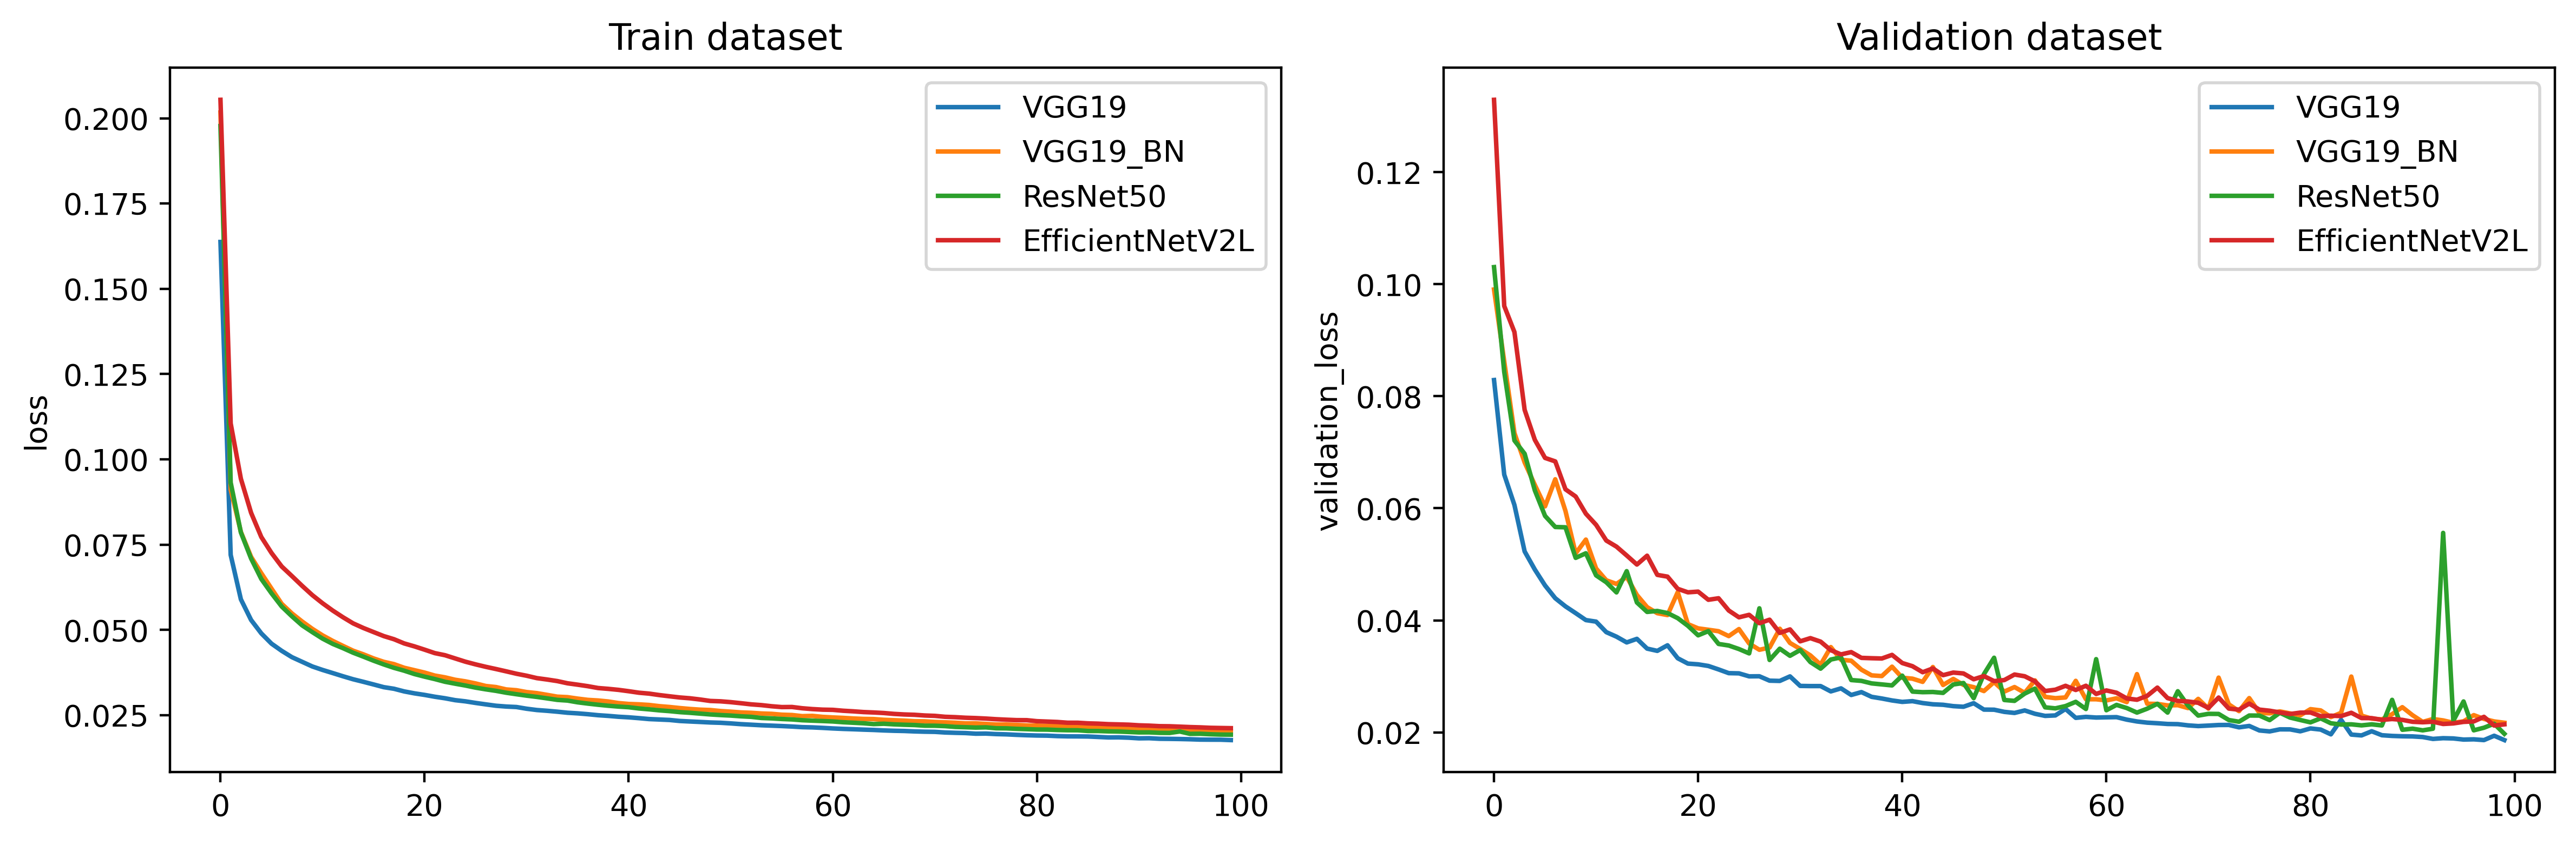

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400, tight_layout=True)
for k, v in learning_curves.items():
    sns.lineplot(
        data=v,
        x=v.index,
        y="loss",
        label=k,
        ax=ax[0],
    )
    sns.lineplot(
        data=v,
        x=v.index,
        y="validation_loss",
        label=k,
        ax=ax[1],
    )
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")
plt.show()
fig.savefig(fname=save_folder / "learning_curves.png")

In [39]:
stdev = {k: v.rolling(window=10).std() for k, v in learning_curves.items()}

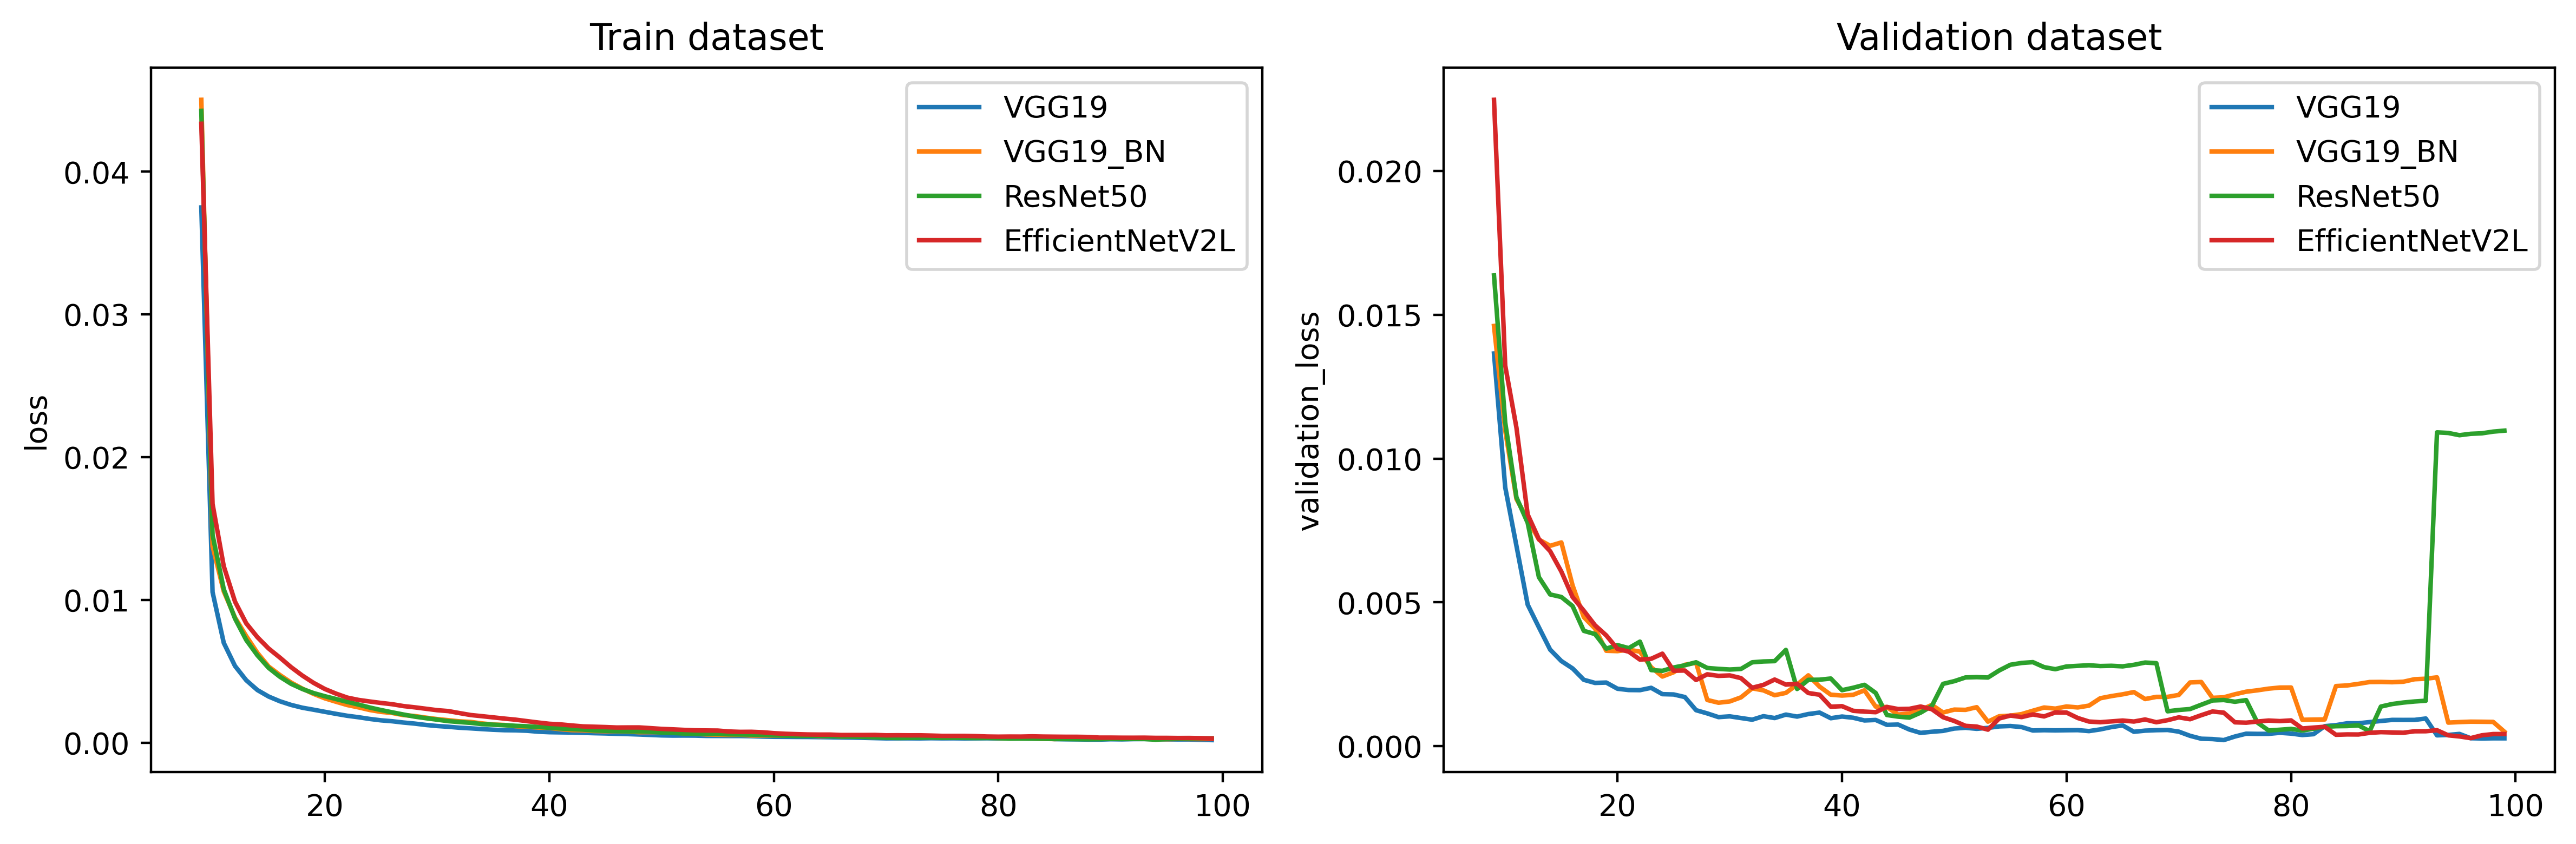

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400, tight_layout=True)
for k, v in stdev.items():
    sns.lineplot(
        data=v,
        x=v.index,
        y="loss",
        label=k,
        ax=ax[0],
    )
    sns.lineplot(
        data=v,
        x=v.index,
        y="validation_loss",
        label=k,
        ax=ax[1],
    )
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")
plt.show()
fig.savefig(fname=save_folder / "stdevs.png")

In [52]:
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score
from toolkit.classes import DataFrameCreator

In [55]:
threshold_multipl = np.linspace(0, 3, 100, endpoint=True)

losses = {
    "VGG19": pd.read_csv("./results/vgg19_vgg19/20230510_172958_losses.csv", index_col="img_no"),
    "VGG19_BN": pd.read_csv("./results/vgg19_bn_vgg19/20230525_045131_losses.csv", index_col="img_no"),
    "ResNet50": pd.read_csv("./results/resnet50_vgg19/20230514_213740_losses.csv", index_col="img_no"),
    "EfficientNetV2L": pd.read_csv("./results/efficientnetv2l_vgg19/20230525_194238_losses.csv", index_col="img_no"),
}

data = DataFrameCreator()
data_folder = Path("./data/")
samples = ["sd1_sample"]

for sample in samples:
    data.load_dataset(
        sample_dir=data_folder / sample,
        labels={"normal": 0, "grass": 1, "double_rail": 2},
    )

y_true = data["dataset"]["label"] != "normal"

  0%|          | 0/8640 [00:00<?, ?it/s]

[    INFO    ] Images loaded from data/sd1_sample with label normal


  0%|          | 0/64 [00:00<?, ?it/s]

[    INFO    ] Images loaded from data/sd1_sample with label grass


  0%|          | 0/29 [00:00<?, ?it/s]

[    INFO    ] Images loaded from data/sd1_sample with label double_rail


In [56]:
losses["VGG19"], y_true

(            loss
 img_no          
 0       0.018478
 1       0.021017
 2       0.019445
 3       0.017864
 4       0.018877
 ...          ...
 8728    0.020781
 8729    0.020440
 8730    0.017562
 8731    0.016774
 8732    0.019679
 
 [8733 rows x 1 columns],
 0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 8728    False
 8729    False
 8730    False
 8731    False
 8732    False
 Name: label, Length: 8733, dtype: bool)

In [69]:
res = {}
for k, loss in losses.items():
    res[k] = pd.DataFrame(columns=["Recall", "F1_score", "Balanced_acc"])
    loss_mean = np.mean(loss)
    loss_std = np.std(loss)
    for multipl in threshold_multipl:
        loss_threshold = loss_mean + multipl * loss_std
        y_pred = loss >= loss_threshold
        df = pd.DataFrame(
            data={
                "Recall": recall_score(y_true, y_pred),
                "F1_score": f1_score(y_true, y_pred),
                "Balanced_acc": balanced_accuracy_score(y_true, y_pred),
            },
            index=[multipl],
        )
        res[k] = pd.concat([res[k], df])

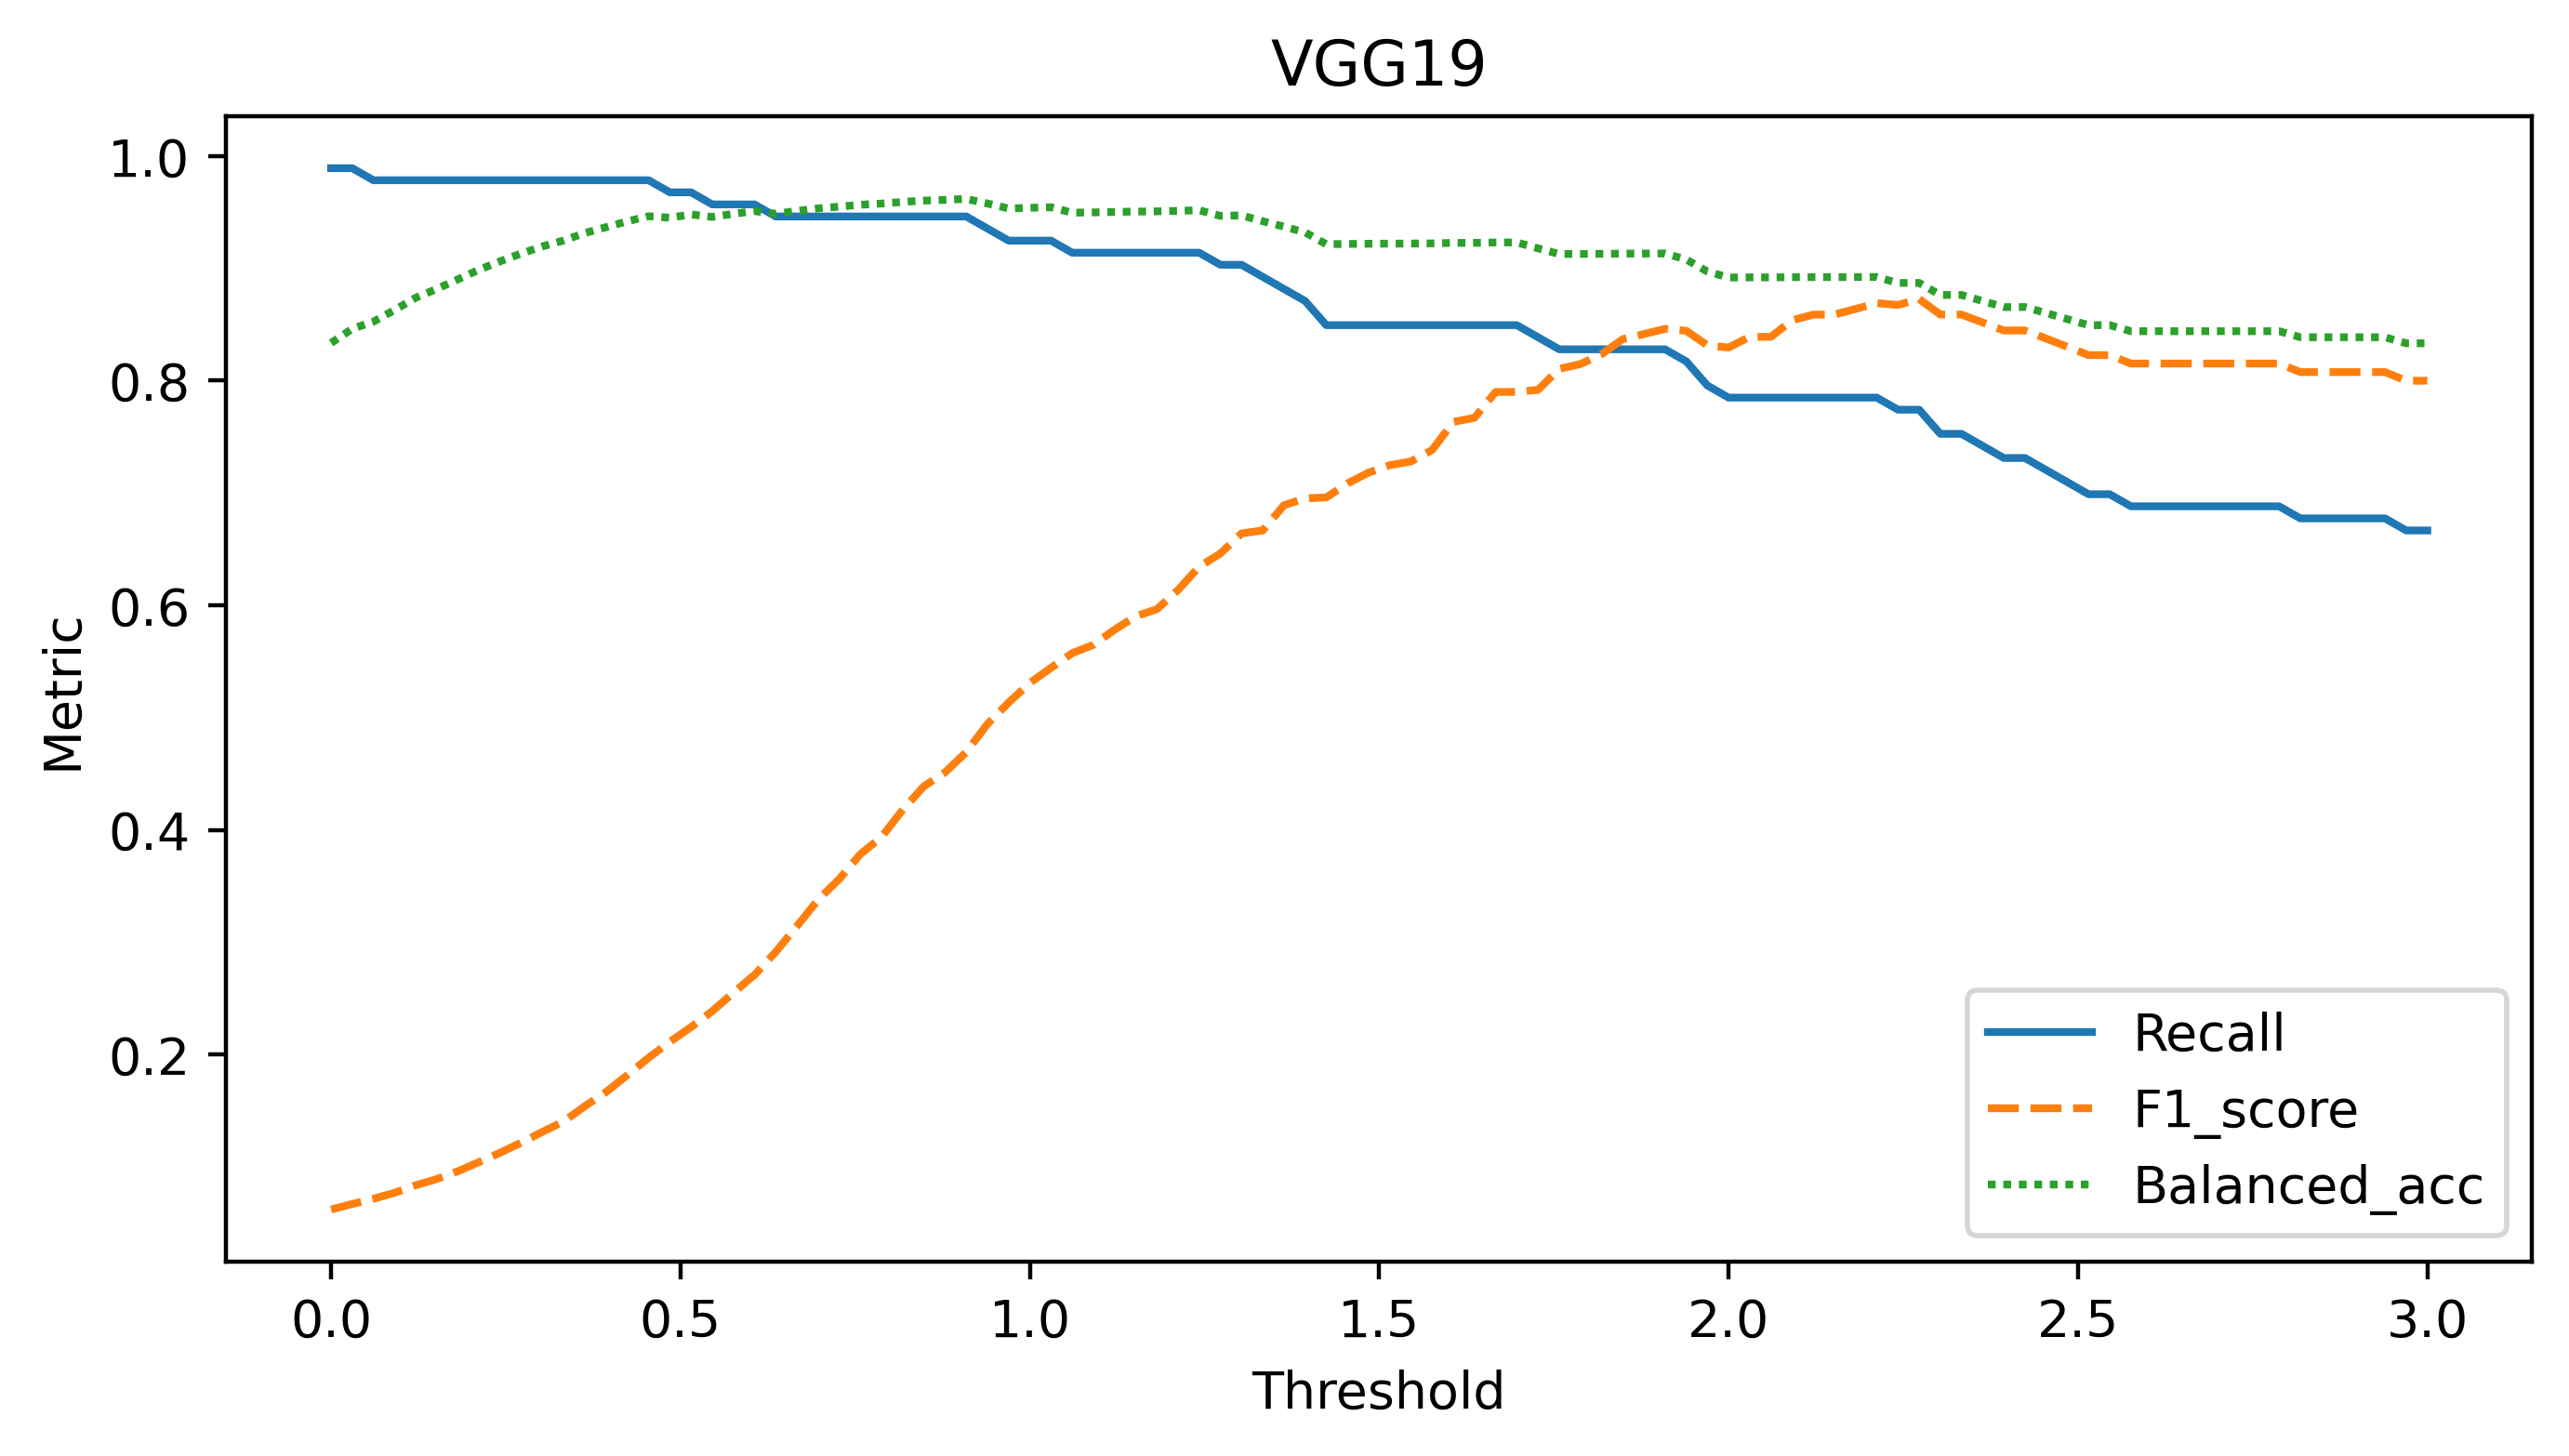

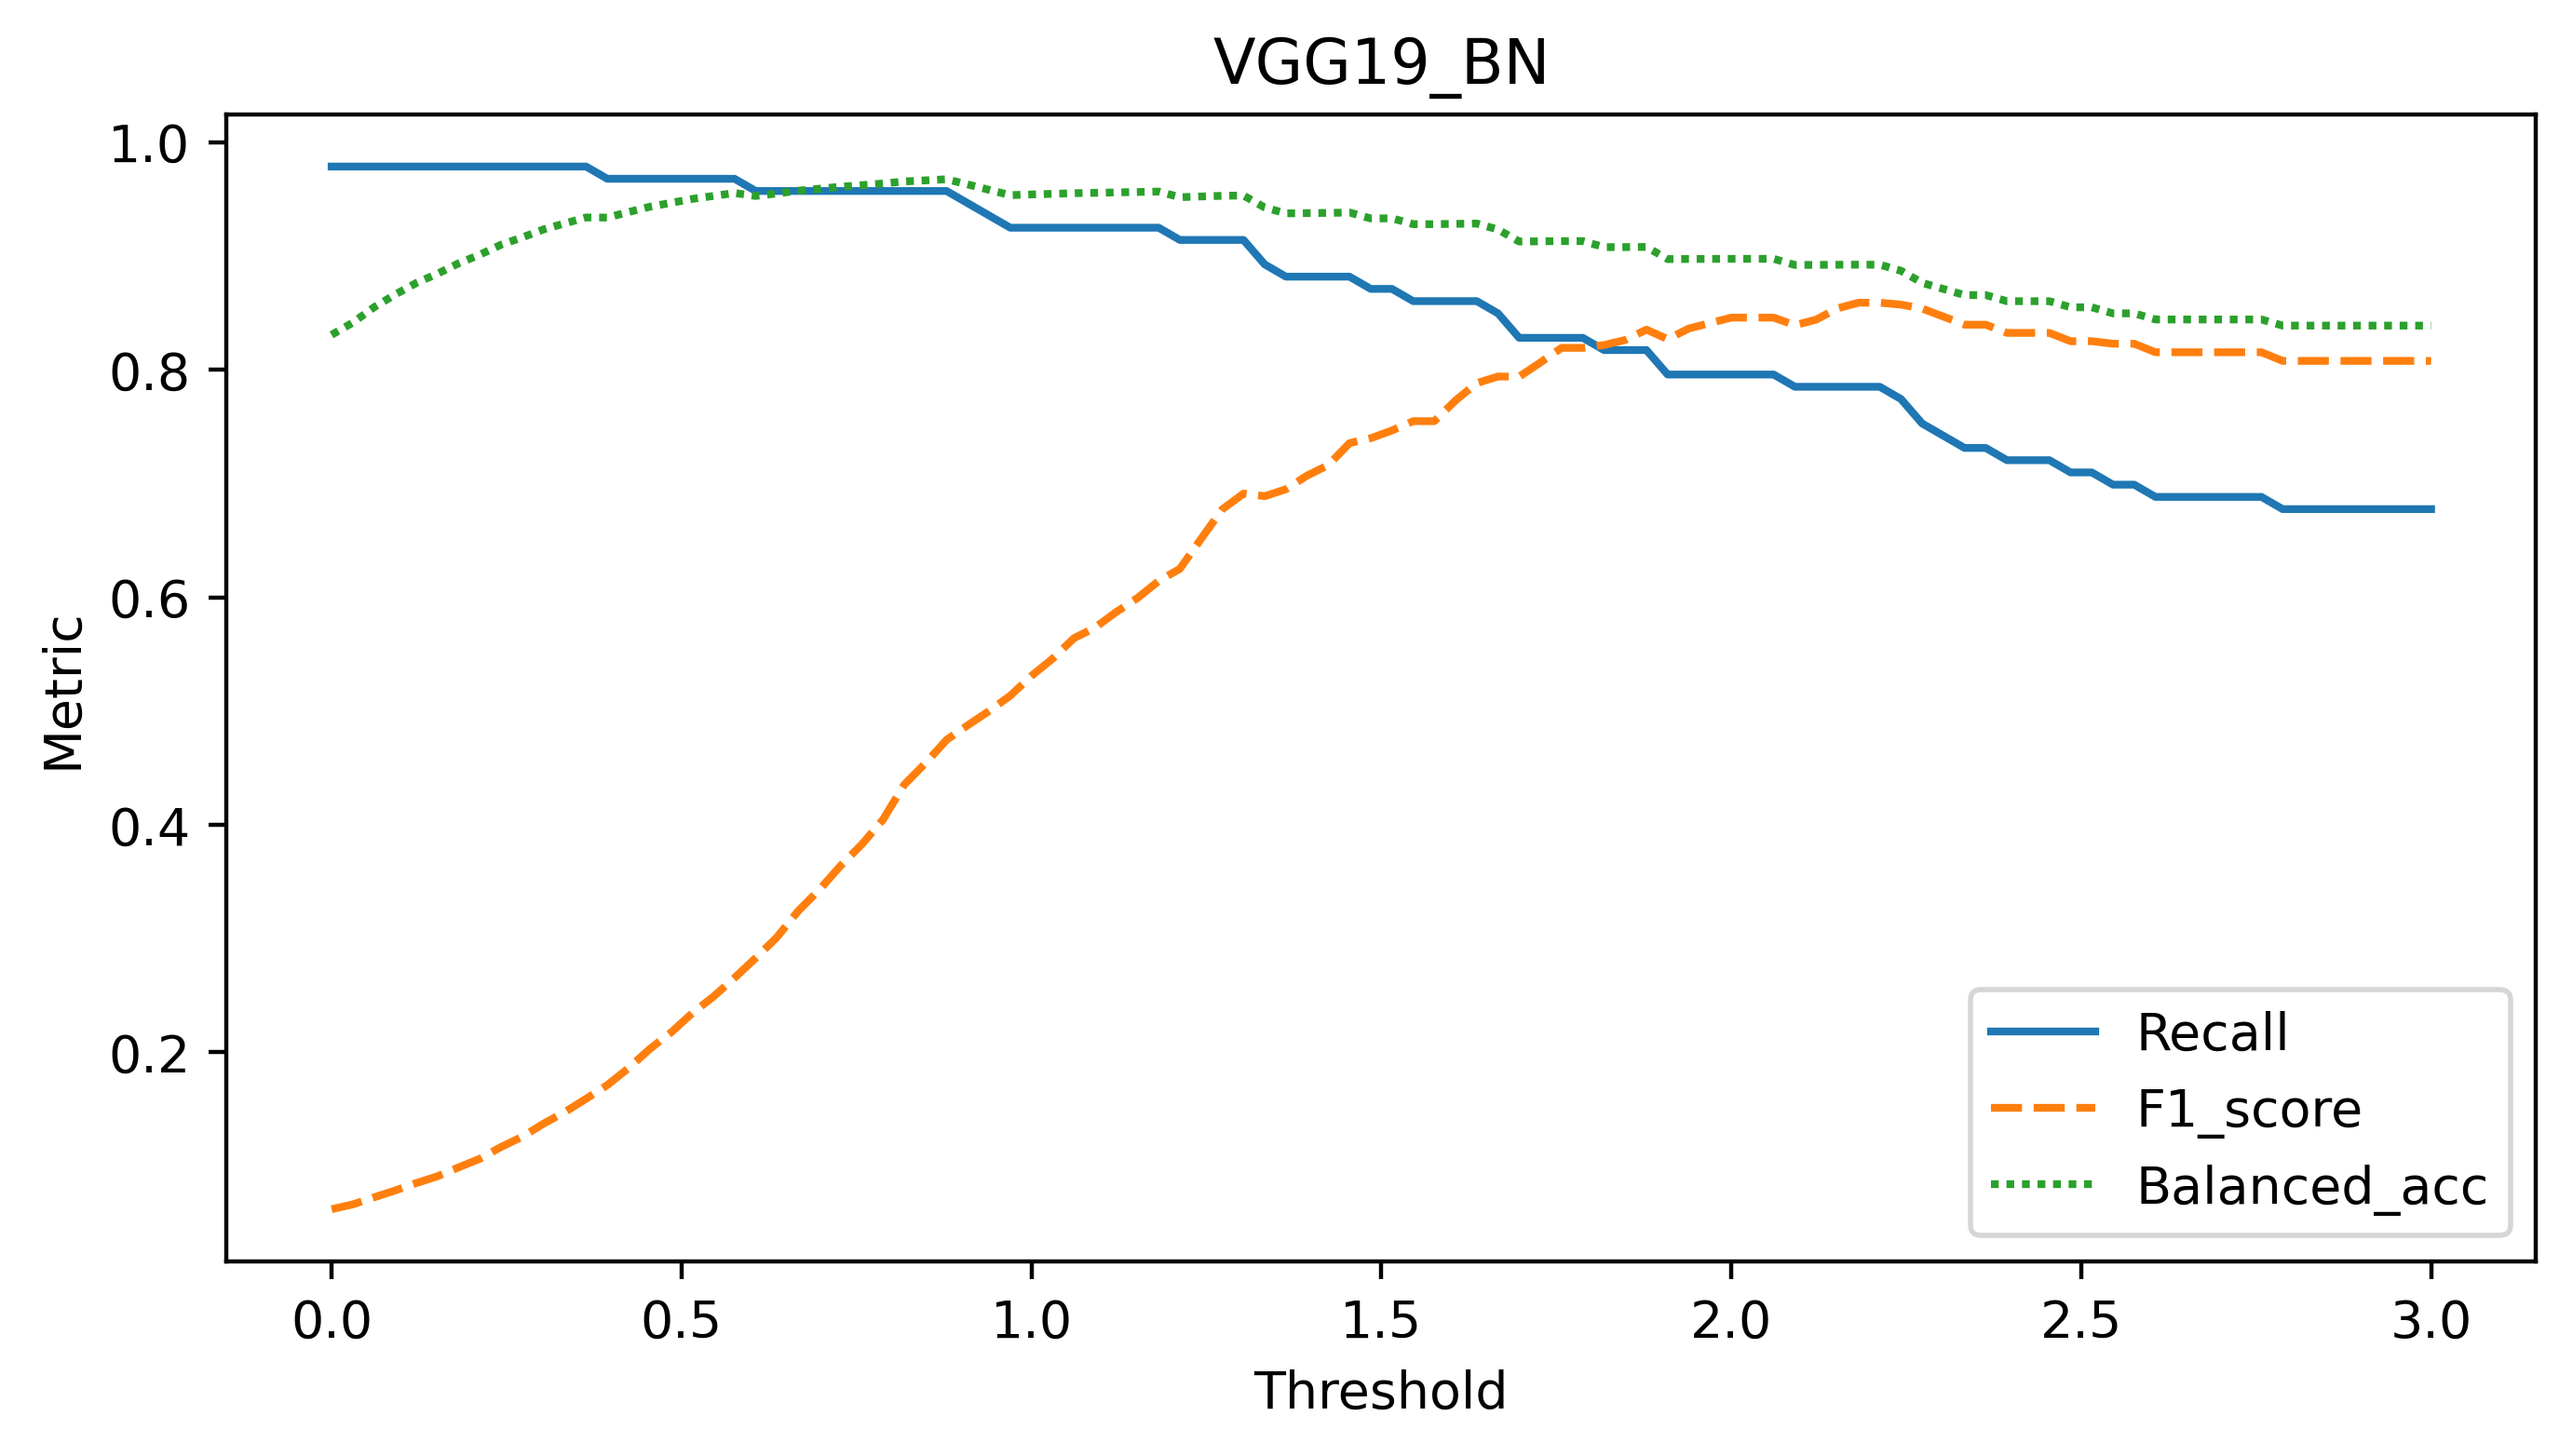

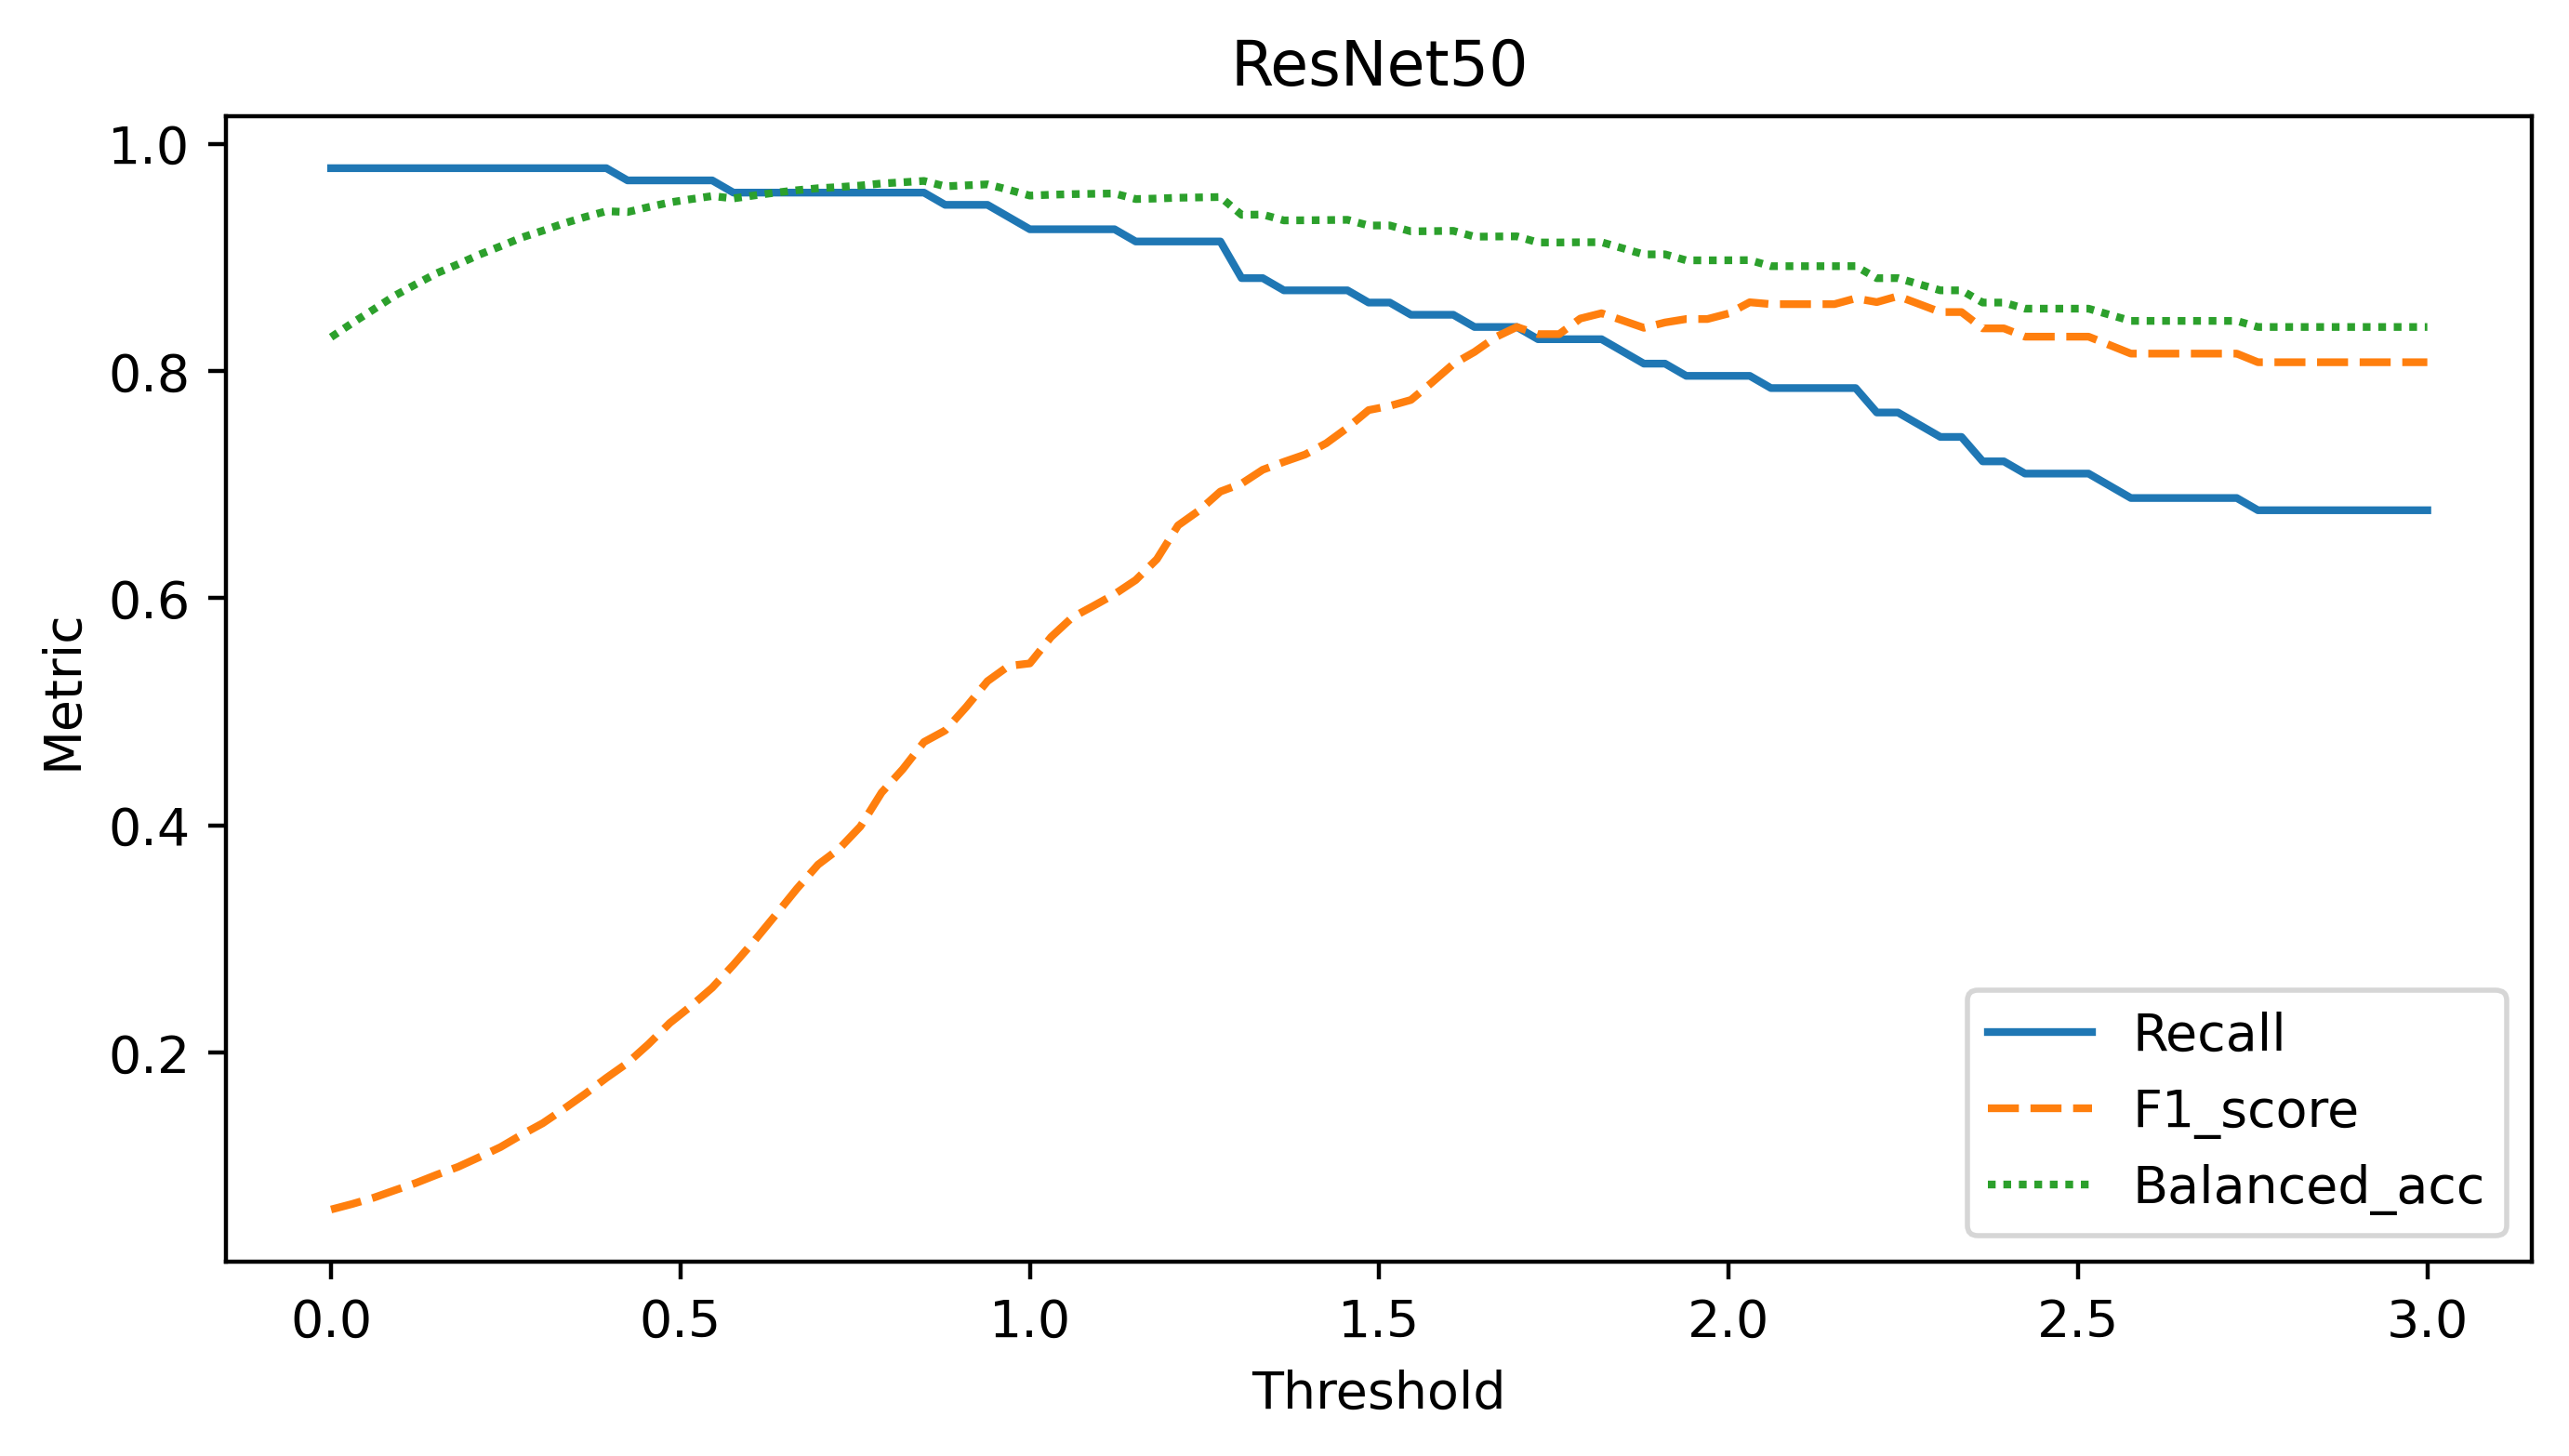

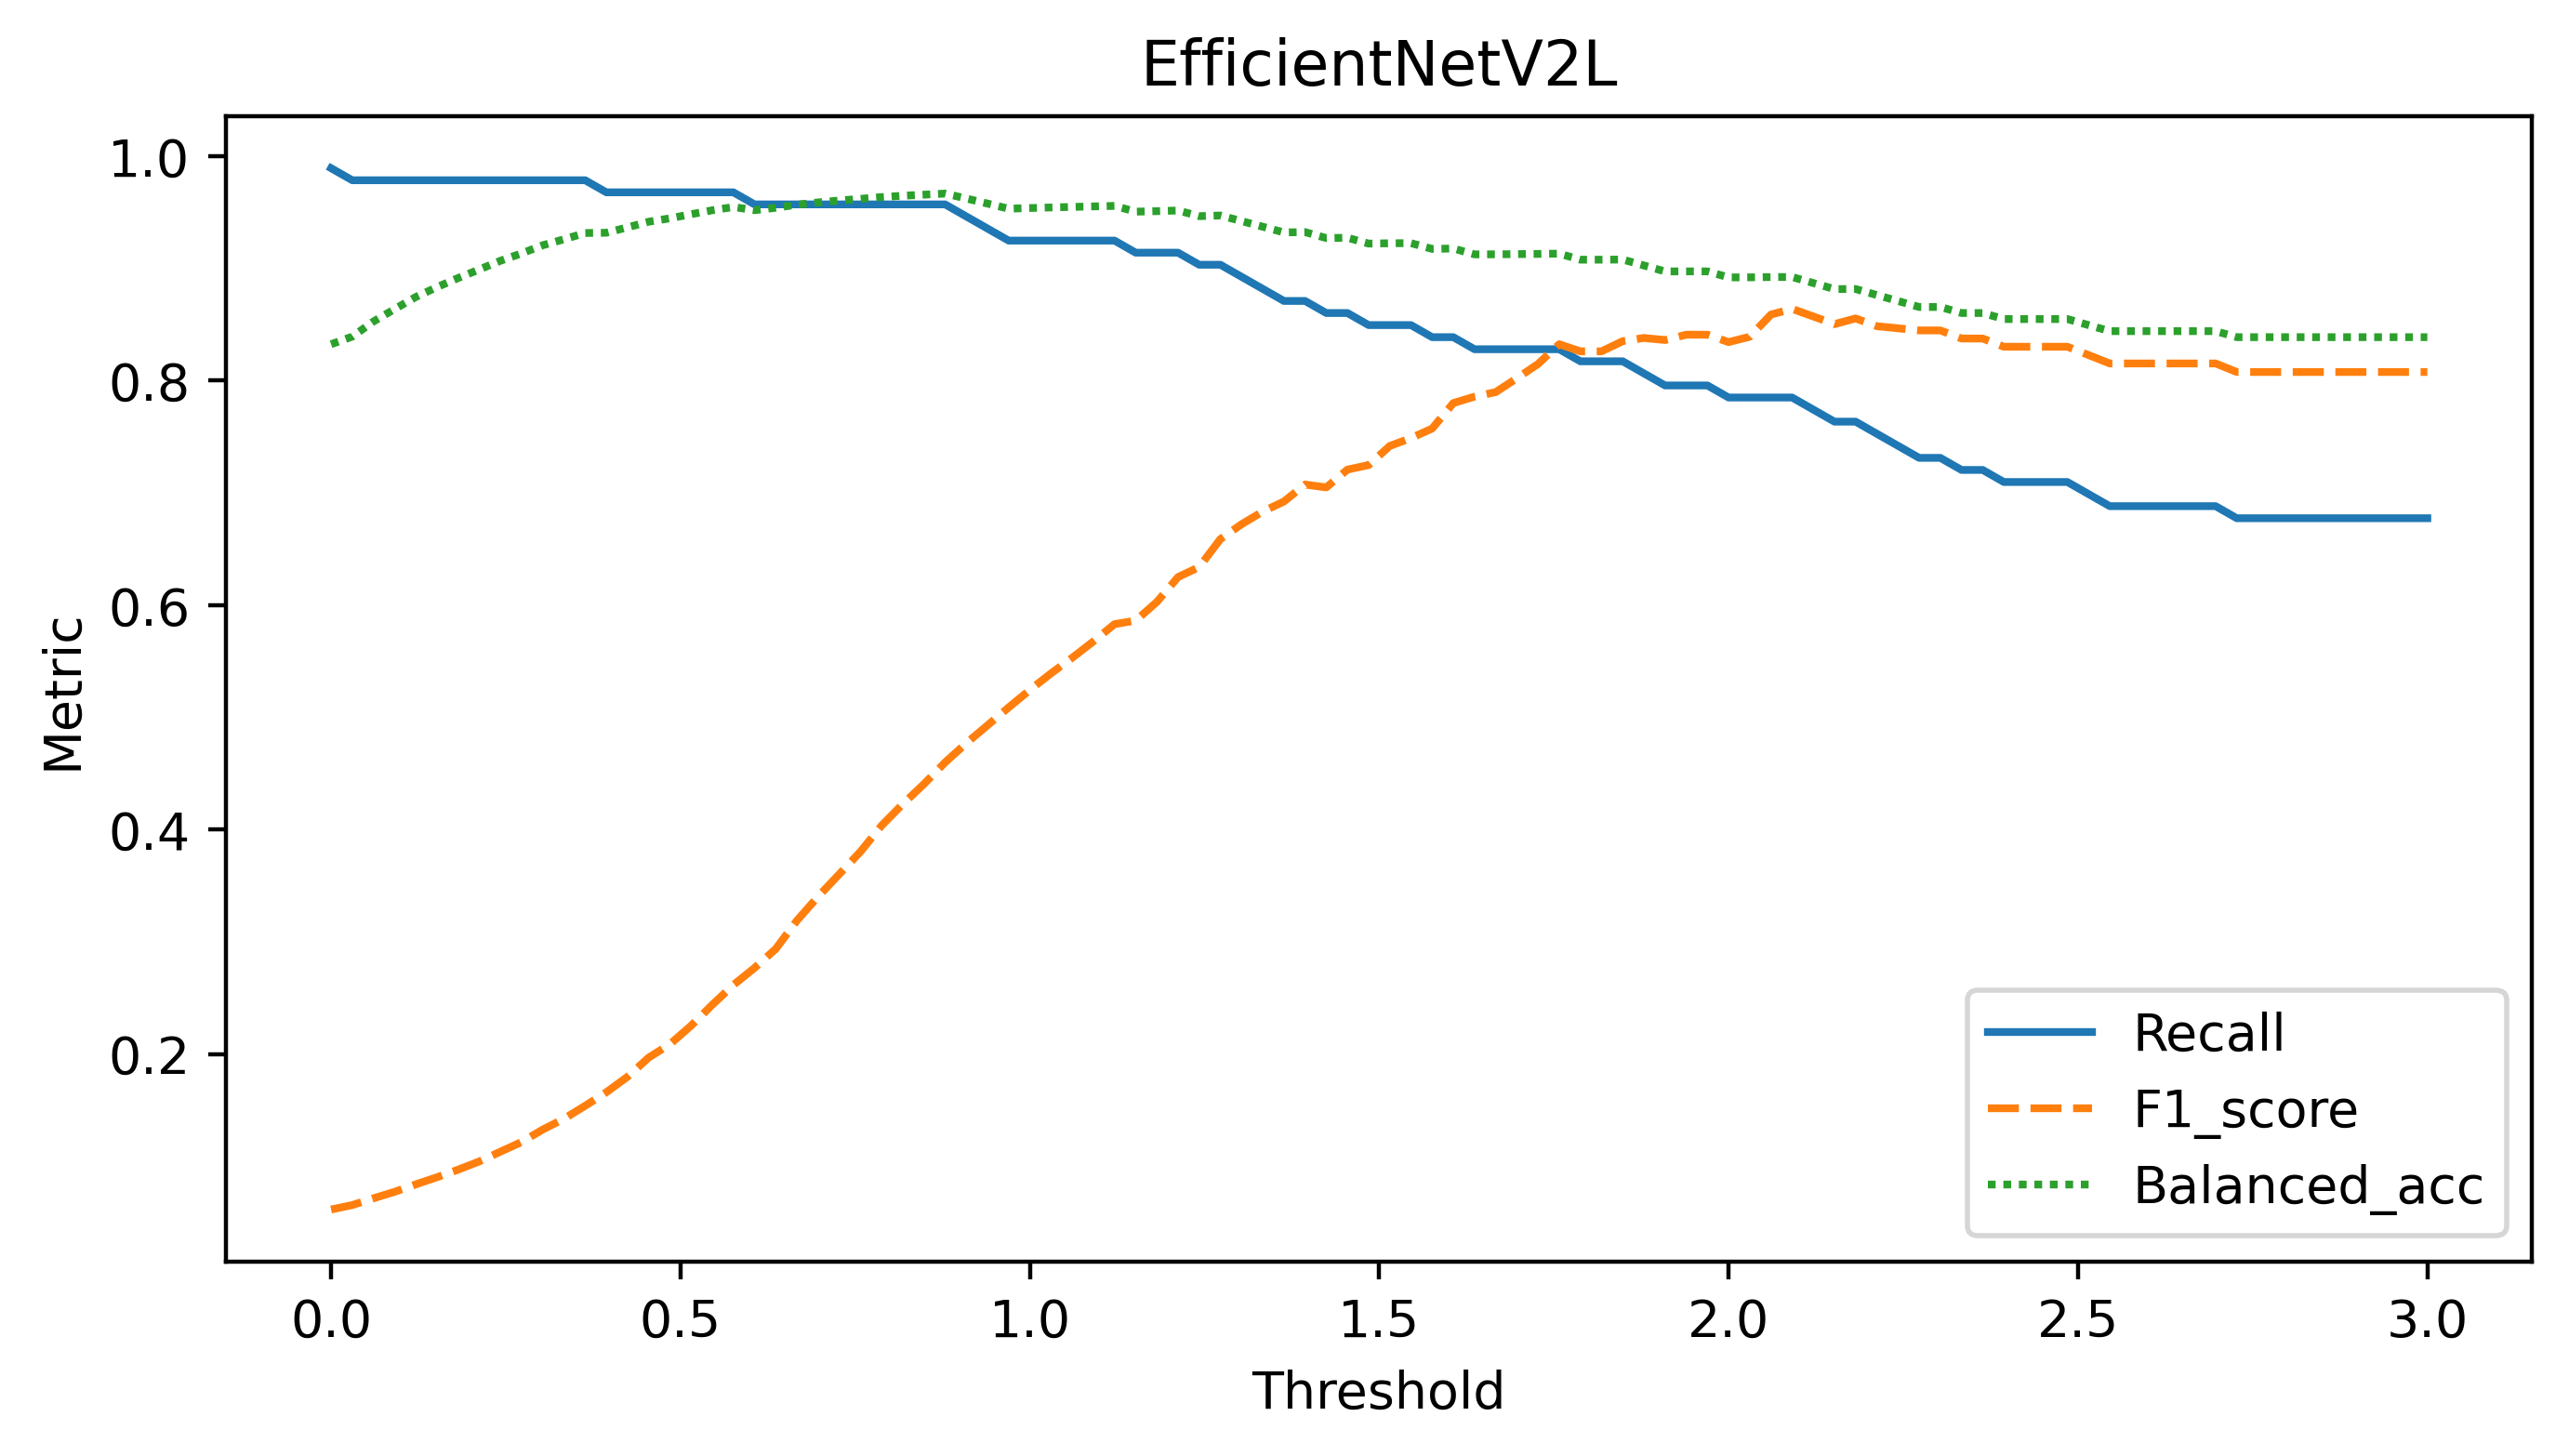

In [72]:
for k, v in res.items():
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=400)
    sns.lineplot(data=v, ax=ax)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Metric")
    ax.set_title(k)
    plt.show()
    fig.savefig(fname=save_folder / f"{k}_threshold.png")